In [72]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

# Building the PDF from particle releases

In [8]:
pset_1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')

In [9]:
# for the 16 different depths, declare the indexes of the particles starting at that depth

level_indexes = {}
dz = 100
n_levels = 16

for i in range(n_levels):
    level_indexes[i*dz] = pset_1.trajectory[i::n_levels]

In [10]:
p1 = pset_1.isel(trajectory=level_indexes[0])
# p1.compute()

In [11]:
p1

<xarray.Dataset> Size: 48MB
Dimensions:     (trajectory: 4096, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 33kB 0 16 32 48 ... 65472 65488 65504 65520
Data variables:
    lat         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [12]:
64*64

4096

In [13]:
2**11 + 32

2080

In [199]:
2**11 + 2**5 - 64 - 1

2015

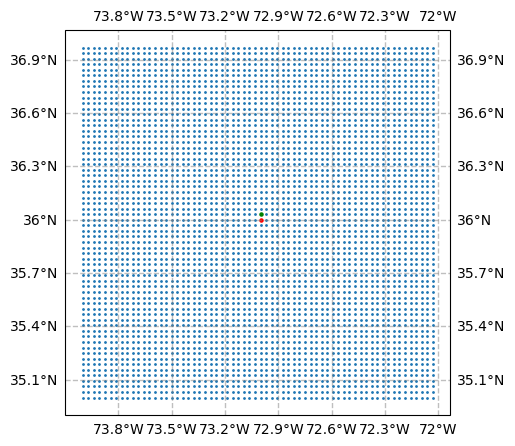

In [194]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-90, -60, 25, 50])
# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p1.lon[:,0], p1.lat[:,0], s=1)
pp = 2**5 + 2**11

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='r')

pp = (2**11) + 2**5 + 64

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='g')


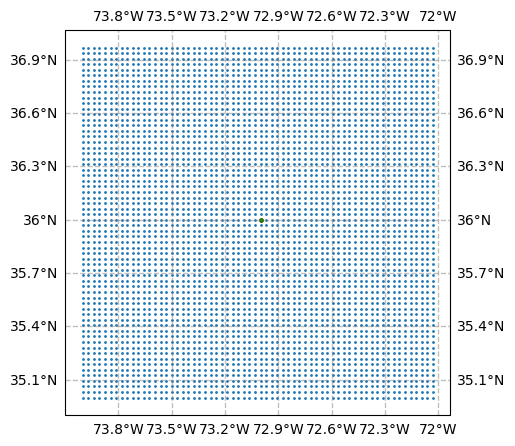

In [155]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-90, -60, 25, 50])
# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p1.lon[:,0], p1.lat[:,0], s=1)
pp = 2**5 + 2**11

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='r')

pp = (2**11 - 1) + 2**5 + 1
plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='g')

In [38]:
pp = 2**5 + 2**11
px1 = p1.isel(trajectory=pp)
px2 = p1.isel(trajectory=pp+1)

In [39]:
px1

<xarray.Dataset> Size: 13kB
Dimensions:     (obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
    trajectory  int64 8B 33280
Data variables:
    lat         (obs) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    lon         (obs) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    time        (obs) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    z           (obs) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [40]:
xr.concat([px1, px2], dim='trajectory')

<xarray.Dataset> Size: 25kB
Dimensions:     (trajectory: 2, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 16B 33280 33296
Data variables:
    lat         (trajectory, obs) float64 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

# Building the PDF 

# 1. Cross-ensemble 1 particle distribution
We take the same particle at the surface for all 50 member ensemble and build two PDFs.
1. 𝑝(𝑿(𝑡 + 𝜏)−𝑿(𝑡) | 𝑿(𝑡), 𝑡, 𝜏),
where $\vec{X}(t)$ is the position of the particles at time $t$ and $\vec{X}(t + \tau)$ is the position of the particle after $\tau$.

2. Probability of following similar path.


In [62]:
member = 1
path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
pset_member = xr.open_zarr(path)
pset_member = pset_member.isel(trajectory=level_indexes[0])

particle_index = 2**5 + 2**11
pset_member = pset_member.isel(trajectory=particle_index)

for member in tqdm(range(2,51)):
    path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
    pset_member_aux = xr.open_zarr(path)
    pset_member_aux = pset_member_aux.isel(trajectory=level_indexes[0])
    pset_member_aux = pset_member_aux.isel(trajectory=particle_index)
    
    pset_member = xr.concat([pset_member, pset_member_aux], dim='trajectory')
    
    

  6%|▌         | 3/49 [00:00<00:01, 26.74it/s]

100%|██████████| 49/49 [00:05<00:00,  9.45it/s]


In [63]:
pset_member.compute()

<xarray.Dataset> Size: 584kB
Dimensions:     (trajectory: 50, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 400B 33280 33280 33280 ... 33280 33280 33280
Data variables:
    lat         (trajectory, obs) float64 146kB 36.0 35.96 35.87 ... 31.18 31.18
    lon         (trajectory, obs) float64 146kB -73.0 -72.95 ... -75.13 -75.13
    time        (trajectory, obs) datetime64[ns] 146kB 2011-01-02 ... 2011-12-31
    z           (trajectory, obs) float64 146kB 0.0 0.0 ... -9.215e-05
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

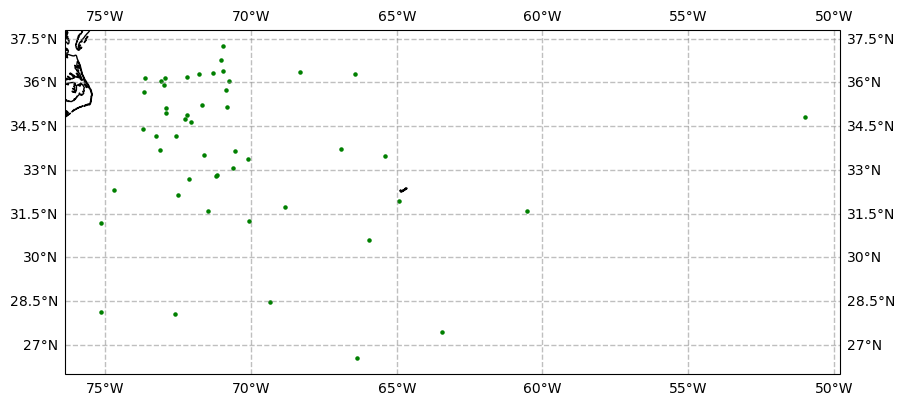

In [152]:
# plot the first 45 particles with land from cartopy
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.set_extent([-180, 180, -90, 90])

# for i in range(400):
# ax.plot(pset_member.lon[:, :].T, pset_member.lat[:, :].T);
tau = 360
ax.scatter(pset_member.lon[:,tau], pset_member.lat[:,tau], s=5, c='g')
# ax.set_title('Member 001 Jan-Dec 2010 | Surface release')

In [65]:
pset_member.lon[:, 0].values

array([-73., -73., -73., -73., -73., -73., -73., -73., -73., -73., -73.,
       -73., -73., -73., -73., -73., -73., -73., -73., -73., -73., -73.,
       -73., -73., -73., -73., -73., -73., -73., -73., -73., -73., -73.,
       -73., -73., -73., -73., -73., -73., -73., -73., -73., -73., -73.,
       -73., -73., -73., -73., -73., -73.])

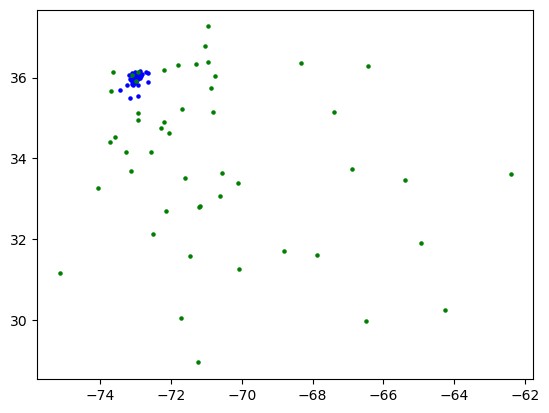

In [70]:
tau = 0
plt.scatter(pset_member.lon[:,tau], pset_member.lat[:,tau], s=5, c='r')
tau = 1
plt.scatter(pset_member.lon[:,tau], pset_member.lat[:,tau], s=5, c='b')
tau = 200
plt.scatter(pset_member.lon[:,tau], pset_member.lat[:,tau], s=5, c='g')

In [147]:
# Assuming you have arrays of longitude and latitude
tau = 300
lon = pset_member.lon[:,tau].values
lat = pset_member.lat[:,tau].values

# Stack the longitude and latitude arrays into a 2D array
particles = np.vstack([lon, lat]).T
particles *= np.pi / 180  # Convert degrees to radians

nx, ny = 81, 61
domain_limits = [[-80, -40], [15, 45]]

xgrid = np.linspace(domain_limits[0][0], domain_limits[0][1], nx)
ygrid = np.linspace(domain_limits[1][0], domain_limits[1][1], ny)

X, Y = np.meshgrid(xgrid, ygrid)

xy = np.vstack([X.ravel(), Y.ravel()]).T
xy *= np.pi / 180  # Convert degrees to radians


# # Create and fit the KernelDensity model
kde = KernelDensity(
        bandwidth=0.005, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
kde.fit(particles)

Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# # Compute the densities (log probability density function)
# log_dens = kde.score_samples(X)

# # Convert log densities to actual densities
# dens = np.exp(log_dens)

In [148]:
Z

array([[5.64387068e-92, 2.85308212e-81, 6.89250140e-72, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.05826528e-90, 2.53219539e-79, 7.54822737e-70, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.55972362e-88, 1.95868280e-77, 7.15806340e-68, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.31300828e-80, 2.40769411e-69, 2.10587627e-59, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.87463381e-82, 5.97373979e-71, 4.39411816e-61, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00161707e-83, 1.28993125e-72, 7.92788406e-63, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

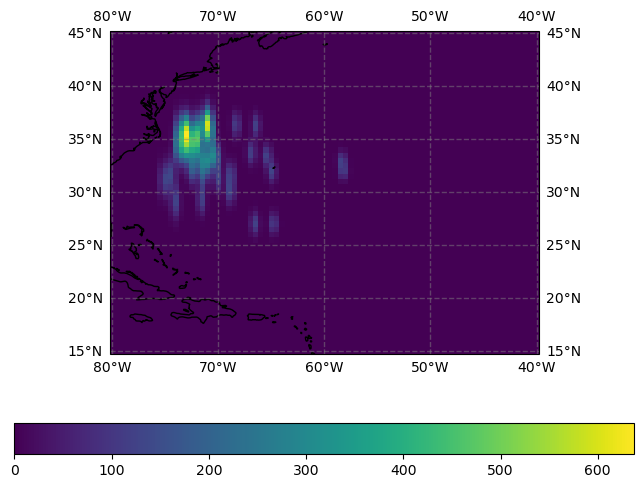

In [178]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
im = ax.pcolormesh(X, Y, Z)
fig.colorbar(im, orientation='horizontal')


In [167]:
nx, ny = 41, 31
domain_limits = [[-80, -40], [15, 45]]
time = 0

P = np.zeros((364, nx, ny))

for time in tqdm(range(0, 364)):
    p_aux, x_, y_ = np.histogram2d(pset_member.lon[:, time].T, pset_member.lat[:, time].T, bins=[nx, ny], range=domain_limits, density=True)
    P[time] = p_aux


100%|██████████| 364/364 [02:28<00:00,  2.45it/s]


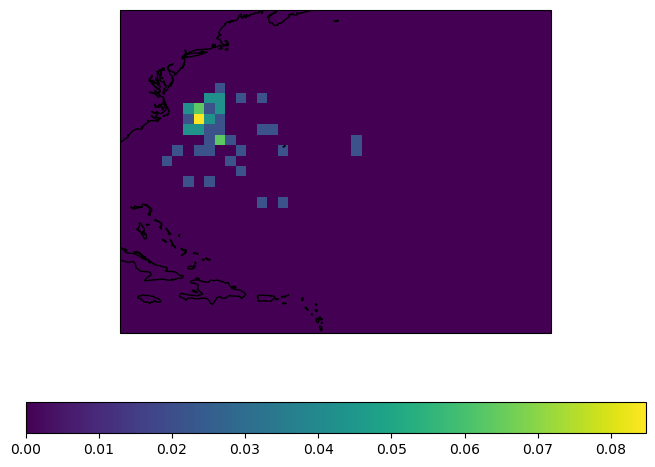

In [180]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
tau = 300
im = ax.pcolormesh(x_, y_, P[tau].T)
fig.colorbar(im, orientation='horizontal')

In [177]:
P[50].sum()

1.0591666666666688